In [1]:
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import TimedAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import tqdm
import pickle
import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema, savgol_filter
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

import jax
import jax.numpy as jnp
import jaxopt
jax.config.update("jax_enable_x64", True)

from tinygp import kernels, GaussianProcess

from pytisean import tiseano, tiseanio

In [2]:
cadences = np.array((0.01, 0.05, 0.1))
Ncyc = np.array((5,10,50))

### Gaussian noise

In [3]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise = np.random.normal(0.,1.,len(t))
#sp.plotTimeSeries(t, gaussianNoise,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Gaussian noise")

### Multiperiodic signals

In [4]:
dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

v1 = 2*np.pi*(1./23.)
v2 = 2*np.pi*(1./29.)

trueFreqs = np.array((1./23.,1./29.))

simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))
simplePeriodic = simplePeriodic/np.mean(simplePeriodic)
#sp.plotTimeSeries(t, simplePeriodic,min_freq=(1./baseline),max_freq=(1./(2.*dt)), nq=10, spp=100, 
#               LS_xlim = (0.1*np.min(trueFreqs),2*np.max(trueFreqs)), plot_harmonics=True, 
#               true_freq=trueFreqs,title="Sum of sines")


In [5]:
# multi-periodic signal from Kovacs & Buchler 1988
dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = sp.KB88(t)

trueFreqs = np.array((0.1, 0.048, 0.0252, 0.1+0.048, 0.1-0.048, 0.048+0.0252, 0.048-0.0252, 0.1+0.0252, 0.1-0.0252, 2*0.1, 2*0.048,))

#sp.plotTimeSeries(t, multiPeriodic_r, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
#               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, plot_harmonics=True, title="KB88 R(t)")
#sp.plotTimeSeries(t, multiPeriodic_v, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
#               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, title="KB88 v(t)")


### load in Rossler, transformed Rossler, Lorenz time series

In [6]:
rossler_x_f = ! ls ./corrDimTesting/rossler/rossler_x_P*.npy
rossler_y_f = ! ls ./corrDimTesting/rossler/rossler_y_P*.npy
rossler_z_f = ! ls ./corrDimTesting/rossler/rossler_z_P*.npy

rossler_f = list(rossler_x_f) + list(rossler_y_f) + list(rossler_z_f)

transformed_rossler_x_f = ! ls ./corrDimTesting/transformed_rossler/transformed_rossler_x_P*.npy
transformed_rossler_y_f = ! ls ./corrDimTesting/transformed_rossler/transformed_rossler_y_P*.npy
transformed_rossler_z_f = ! ls ./corrDimTesting/transformed_rossler/transformed_rossler_z_P*.npy
transformed_rossler_f = list(transformed_rossler_x_f) + list(transformed_rossler_y_f) + list(transformed_rossler_z_f)

lorenz_x_f = ! ls ./corrDimTesting/lorenz/lorenz_x_P*.npy
lorenz_y_f = ! ls ./corrDimTesting/lorenz/lorenz_y_P*.npy
lorenz_z_f = ! ls ./corrDimTesting/lorenz/lorenz_z_P*.npy
lorenz_f = list(lorenz_x_f) + list(lorenz_y_f) + list(lorenz_z_f)

print(len(rossler_f))
print(len(transformed_rossler_f))
print(len(lorenz_f))

81
81
81


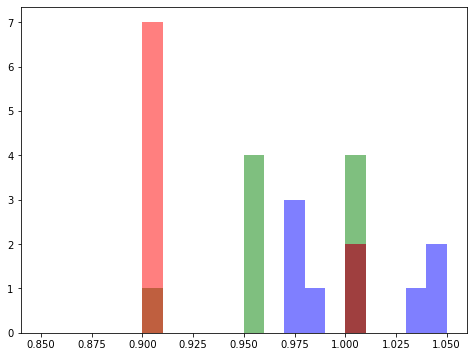

In [7]:
# test that expected QP is recovered, even for low-cadence time series
recovered_qp_001 = []
recovered_qp_005 = []
recovered_qp_01 = []
for ts in lorenz_z_f:
    timeSeries = np.load(ts)
    
    fileName = ts.split("/")[-1]
    #print(fileName)
    timeFileName = fileName.split("Pq")[0] + "t_Pq" + fileName.split("Pq")[1]

    time = np.load("/".join(ts.split("/")[:-1]) + "/" + timeFileName)
    #fig, axes = plt.subplots(1,1, figsize=(8,6))
    #plt.plot(time,timeSeries,'k.')
    #plt.show()
    if "transformed" in fileName:
        varname = fileName.split("_")[2]
    else:
        varname = fileName.split("_")[1]

    details = "Pq" + fileName.split("Pq")[1].split(".npy")[0]
    Pq = float(details.split("Pq=")[1].split("_")[0])
    cad = float(details.split("cad=")[1].split("_")[0])
    Ncyc = int(details.split("Ncyc=")[1].split("_")[0])
    version = int(details.split("_v")[1])
    
    if "lorenz" in fileName and varname != "z":
        qp = sp.estimateQuasiPeriod(time, timeSeries, method="localMaxSep", plot=False) 
    else:
        qp = sp.estimateQuasiPeriod(time, timeSeries, method="power", plot=False) # in units of test cadence, dt = 0.01 #alternative method="localMaxSep"
    #print(cad)
    #print(qp)
    if cad == 0.01:
        recovered_qp_001.append(qp*cad)
    elif cad == 0.05:
        recovered_qp_005.append(qp*cad)
    elif cad == 0.1:
        recovered_qp_01.append(qp*cad)
    

fig2, ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(np.array(recovered_qp_001),color='b', alpha=0.5, bins=20, range=(0.85,1.05))
ax.hist(np.array(recovered_qp_005),color='g', alpha=0.5, bins=20, range=(0.85,1.05))
ax.hist(np.array(recovered_qp_01),color='r', alpha=0.5, bins=20, range=(0.85,1.05))
plt.show()

# getting started with TinyGP

<class 'jaxlib.xla_extension.DeviceArray'>
(5, 1000)


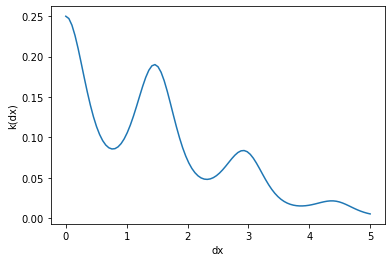

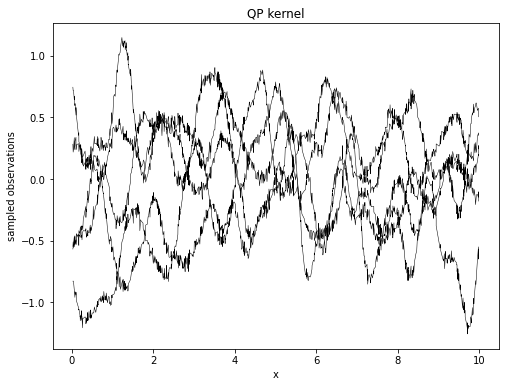

(800,)
(800,)


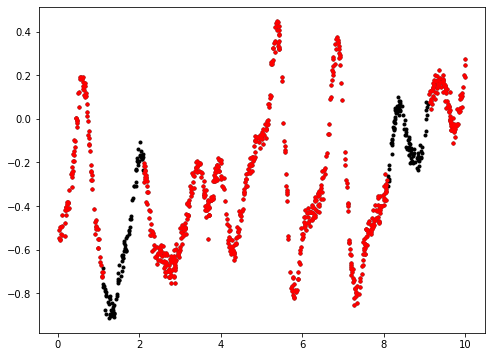

In [24]:
alpha = 0.5
lambda_1 = 2
lambda_2 = 1.5
gamma = 1

kernel = alpha**2 * kernels.ExpSquared(scale=lambda_1) * kernels.ExpSineSquared(scale=lambda_2, gamma=gamma)

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")

plot_kernel(kernel)

X = np.sort(np.random.default_rng(1).uniform(0, 10, 1000))

gp = GaussianProcess(kernel, X, diag=1.e-3)

fig, ax = plt.subplots(1,1,figsize=(8,6))
y = gp.sample(jax.random.PRNGKey(4), shape=(5,))
print(type(y))
print(np.shape(y))
ax.plot(X, y.T, color="k", lw=0.5)
ax.set_xlabel("x")
ax.set_ylabel("sampled observations")
ax.set_title("QP kernel")
plt.show()


# test data to train a GP on, below
test_t = X
test_y = y[0]

test_t_holdout = np.concatenate((test_t[0:100], test_t[200:800], test_t[900:]))
test_y_holdout = np.concatenate((test_y[0:100], test_y[200:800], test_y[900:]))
print(np.shape(test_t_holdout))
print(np.shape(test_y_holdout))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(test_t, test_y,'k.')
ax.plot(test_t_holdout, test_y_holdout,'r.')
plt.show()

In [25]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amp = jnp.exp(theta["log_amp"])
    lambda1 = jnp.exp(theta["log_lambda1"])
    lambda2 = jnp.exp(theta["log_lambda2"])
    gamma = jnp.exp(theta["log_gamma"])
        
    kernel = amp * kernels.ExpSquared(scale=lambda1) * kernels.ExpSineSquared(scale=lambda2, gamma=gamma)

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "mean": np.float64(0.),
    "log_diag": np.log(1.e-2),
    "log_amp": np.log(1.0),
    "log_lambda1": np.log(1.0),
    "log_lambda2": np.log(1.0),
    "log_gamma": np.log(1.0),
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

#print(f"Initial negative log likelihood: {obj(theta_init, test_t_holdout, test_y_holdout)[0]}")
#print(f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, test_t_holdout, test_y_holdout)[1]}")

In [26]:
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=test_t_holdout, y=test_y_holdout)
print(f"Final negative log likelihood: {soln.state.fun_val}")


Final negative log likelihood: -1496.3627819115607


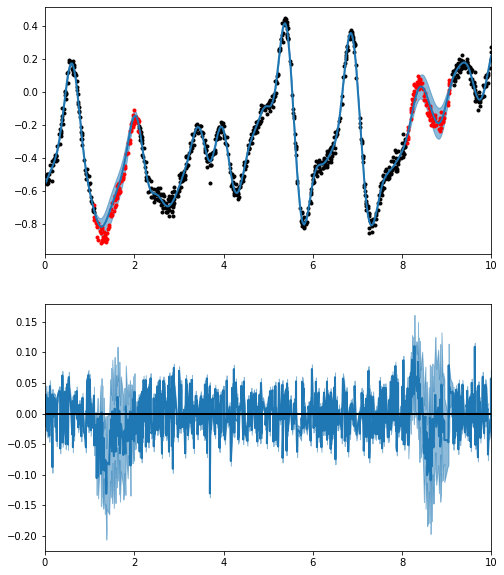

In [29]:
#print(np.shape(test_t))
#print(np.shape(test_y))
gp = build_gp(soln.params, test_t_holdout)
cond_gp = gp.condition(test_y_holdout, test_t).gp
mu, var = cond_gp.loc, cond_gp.variance

fig, axes = plt.subplots(2,1,figsize=(8,10))
axes[0].plot(test_t_holdout, test_y_holdout, "k.")
axes[0].plot(test_t[100:200], test_y[100:200],"r.")
axes[0].plot(test_t[800:900], test_y[800:900],"r.")

axes[0].fill_between(
    test_t, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)

axes[0].plot(test_t, mu, color="C0", lw=2)

axes[1].plot(test_t, test_y - mu, color="C0", lw=2)
axes[1].fill_between(
    test_t, test_y - mu + np.sqrt(var), test_y - mu - np.sqrt(var), color="C0", alpha=0.5
)
axes[1].axhline(0,color='k',lw=2)

for ax in axes:
    ax.set_xlim(0,10)
plt.show()


### load in Rossler, transformed Rossler, Lorenz dimensions

In [43]:
rossler_x_C0 = ! ls ./corrDimTesting/rossler/cArrs/rossler_x_P*C0.npy
rossler_y_C0 = ! ls ./corrDimTesting/rossler/cArrs/rossler_y_P*C0.npy
rossler_z_C0 = ! ls ./corrDimTesting/rossler/cArrs/rossler_z_P*C0.npy
rossler_C0 = list(rossler_x_C0) + list(rossler_y_C0) + list(rossler_z_C0)

transformed_rossler_x_C0 = ! ls ./corrDimTesting/transformed_rossler/cArrs/transformed_rossler_x_P*C0.npy
transformed_rossler_y_C0 = ! ls ./corrDimTesting/transformed_rossler/cArrs/transformed_rossler_y_P*C0.npy
transformed_rossler_z_C0 = ! ls ./corrDimTesting/transformed_rossler/cArrs/transformed_rossler_z_P*C0.npy
transformed_rossler_C0 = list(transformed_rossler_x_C0) + list(transformed_rossler_y_C0) + list(transformed_rossler_z_C0)

lorenz_x_C0 = ! ls ./corrDimTesting/lorenz/cArrs/lorenz_x_P*C0.npy
lorenz_y_C0 = ! ls ./corrDimTesting/lorenz/cArrs/lorenz_y_P*C0.npy
lorenz_z_C0 = ! ls ./corrDimTesting/lorenz/cArrs/lorenz_z_P*C0.npy
lorenz_C0 = list(lorenz_x_C0) + list(lorenz_y_C0) + list(lorenz_z_C0)

print(len(rossler_C0))
print(len(transformed_rossler_C0))
print(len(lorenz_C0))

162
162
183


### Plot dimension comparisons

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 957
Maximal epsilon in the moment= 2.058961e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 936
Maximal epsilon in the moment= 2.058961e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 957
Maximal epsilon in the moment= 2.453053e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 936
Maximal epsilon in the moment= 2.453053e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 951
Maximal epsilon in the moment= 2.417123e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 927
Maximal epsilon in the moment= 2.417123e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4953
Maximal epsilon in the moment= 2.447016e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4930
Maximal epsilon in the moment= 2.447016e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4955
Maximal epsilon in the moment= 2.439542e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4933
Maximal epsilon in the moment= 2.439542e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4955
Maximal epsilon in the moment= 2.439916e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4933
Maximal epsilon in the moment= 2.439916e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 433
Maximal epsilon in the moment= 2.434025e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 411
Maximal epsilon in the moment= 2.434025e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 441
Maximal epsilon in the moment= 2.379768e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 412
Maximal epsilon in the moment= 2.379768e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 457
Maximal epsilon in the moment= 2.428190e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 436
Maximal epsilon in the moment= 2.428190e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 475
Maximal epsilon in the moment= 2.058417e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 463
Maximal epsilon in the moment= 2.058417e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 2.400320e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 455
Maximal epsilon in the moment= 2.400320e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 477
Maximal epsilon in the moment= 2.408036e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 2.408036e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2479
Maximal epsilon in the moment= 2.436608e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2469
Maximal epsilon in the moment= 2.436608e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2479
Maximal epsilon in the moment= 2.426832e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2469
Maximal epsilon in the moment= 2.426832e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2477
Maximal epsilon in the moment= 2.439916e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2466
Maximal epsilon in the moment= 2.439916e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 223
Maximal epsilon in the moment= 2.432586e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 210
Maximal epsilon in the moment= 2.432586e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 216
Maximal epsilon in the moment= 2.316121e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 205
Maximal epsilon in the moment= 2.316121e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 219
Maximal epsilon in the moment= 2.393344e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 209
Maximal epsilon in the moment= 2.393344e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 2.037398e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 2.037398e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 81
Maximal epsilon in the moment= 1.811925e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 75
Maximal epsilon in the moment= 1.811925e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 97
Maximal epsilon in the moment= 2.028467e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 2.028467e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.433683e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.433683e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.414194e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.414194e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.431270e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.431270e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 43
Maximal epsilon in the moment= 1.592709e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 41
Maximal epsilon in the moment= 1.592709e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 48
Maximal epsilon in the moment= 1.420896e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 47
Maximal epsilon in the moment= 1.420896e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 43
Maximal epsilon in the moment= 1.985257e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 41
Maximal epsilon in the moment= 1.985257e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 955
Maximal epsilon in the moment= 2.697621e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 933
Maximal epsilon in the moment= 2.697621e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 936
Maximal epsilon in the moment= 2.654771e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 915
Maximal epsilon in the moment= 2.654771e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 933
Maximal epsilon in the moment= 2.639137e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 911
Maximal epsilon in the moment= 2.639137e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4951
Maximal epsilon in the moment= 2.693977e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4927
Maximal epsilon in the moment= 2.693977e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4930
Maximal epsilon in the moment= 2.681887e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4907
Maximal epsilon in the moment= 2.681887e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4955
Maximal epsilon in the moment= 2.687981e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4933
Maximal epsilon in the moment= 2.687981e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 301
Maximal epsilon in the moment= 2.247216e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 235
Maximal epsilon in the moment= 2.247216e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 463
Maximal epsilon in the moment= 2.586438e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 445
Maximal epsilon in the moment= 2.586438e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 449
Maximal epsilon in the moment= 2.239211e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 424
Maximal epsilon in the moment= 2.239211e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 477
Maximal epsilon in the moment= 2.638891e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 2.638891e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 469
Maximal epsilon in the moment= 2.609598e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 459
Maximal epsilon in the moment= 2.609598e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 481
Maximal epsilon in the moment= 2.618000e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 472
Maximal epsilon in the moment= 2.618000e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2477
Maximal epsilon in the moment= 2.671112e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2466
Maximal epsilon in the moment= 2.671112e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2466
Maximal epsilon in the moment= 2.681887e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2455
Maximal epsilon in the moment= 2.681887e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2477
Maximal epsilon in the moment= 2.687428e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2466
Maximal epsilon in the moment= 2.687428e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 147
Maximal epsilon in the moment= 2.247216e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 113
Maximal epsilon in the moment= 2.247216e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 229
Maximal epsilon in the moment= 2.586438e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 219
Maximal epsilon in the moment= 2.586438e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 225
Maximal epsilon in the moment= 2.216531e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 213
Maximal epsilon in the moment= 2.216531e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 2.009808e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 2.009808e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 2.600263e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 2.600263e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 81
Maximal epsilon in the moment= 1.962948e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 75
Maximal epsilon in the moment= 1.962948e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.648946e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.648946e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.586215e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.586215e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.555591e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.555591e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 37
Maximal epsilon in the moment= 2.117948e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 31
Maximal epsilon in the moment= 2.117948e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 45
Maximal epsilon in the moment= 2.497843e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 43
Maximal epsilon in the moment= 2.497843e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 37
Maximal epsilon in the moment= 2.150019e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 31
Maximal epsilon in the moment= 2.150019e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 949
Maximal epsilon in the moment= 1.664263e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 924
Maximal epsilon in the moment= 1.664263e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 949
Maximal epsilon in the moment= 1.661224e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 924
Maximal epsilon in the moment= 1.661224e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 951
Maximal epsilon in the moment= 1.667650e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 927
Maximal epsilon in the moment= 1.667650e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4951
Maximal epsilon in the moment= 1.669477e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4927
Maximal epsilon in the moment= 1.669477e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4955
Maximal epsilon in the moment= 1.671745e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4933
Maximal epsilon in the moment= 1.671745e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4949
Maximal epsilon in the moment= 1.671841e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4924
Maximal epsilon in the moment= 1.671841e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 451
Maximal epsilon in the moment= 1.584724e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 427
Maximal epsilon in the moment= 1.584724e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 424
Maximal epsilon in the moment= 1.647932e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 399
Maximal epsilon in the moment= 1.647932e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 427
Maximal epsilon in the moment= 1.655086e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 403
Maximal epsilon in the moment= 1.655086e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 477
Maximal epsilon in the moment= 1.663568e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 1.663568e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 477
Maximal epsilon in the moment= 1.661224e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 1.661224e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 475
Maximal epsilon in the moment= 1.667650e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 463
Maximal epsilon in the moment= 1.667650e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2475
Maximal epsilon in the moment= 1.669388e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2463
Maximal epsilon in the moment= 1.669388e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2475
Maximal epsilon in the moment= 1.671710e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2463
Maximal epsilon in the moment= 1.671710e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2475
Maximal epsilon in the moment= 1.671045e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2463
Maximal epsilon in the moment= 1.671045e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 223
Maximal epsilon in the moment= 1.584724e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 210
Maximal epsilon in the moment= 1.584724e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 225
Maximal epsilon in the moment= 1.644936e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 213
Maximal epsilon in the moment= 1.644936e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 227
Maximal epsilon in the moment= 1.655086e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 216
Maximal epsilon in the moment= 1.655086e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 97
Maximal epsilon in the moment= 1.649167e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 1.649167e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 1.652562e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 1.652562e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 1.658963e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 1.658963e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 1.655111e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 1.655111e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 1.666654e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 1.666654e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 1.671045e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 1.671045e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 45
Maximal epsilon in the moment= 1.546016e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 43
Maximal epsilon in the moment= 1.546016e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 47
Maximal epsilon in the moment= 1.597902e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 46
Maximal epsilon in the moment= 1.597902e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 37
Maximal epsilon in the moment= 1.648759e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 31
Maximal epsilon in the moment= 1.648759e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


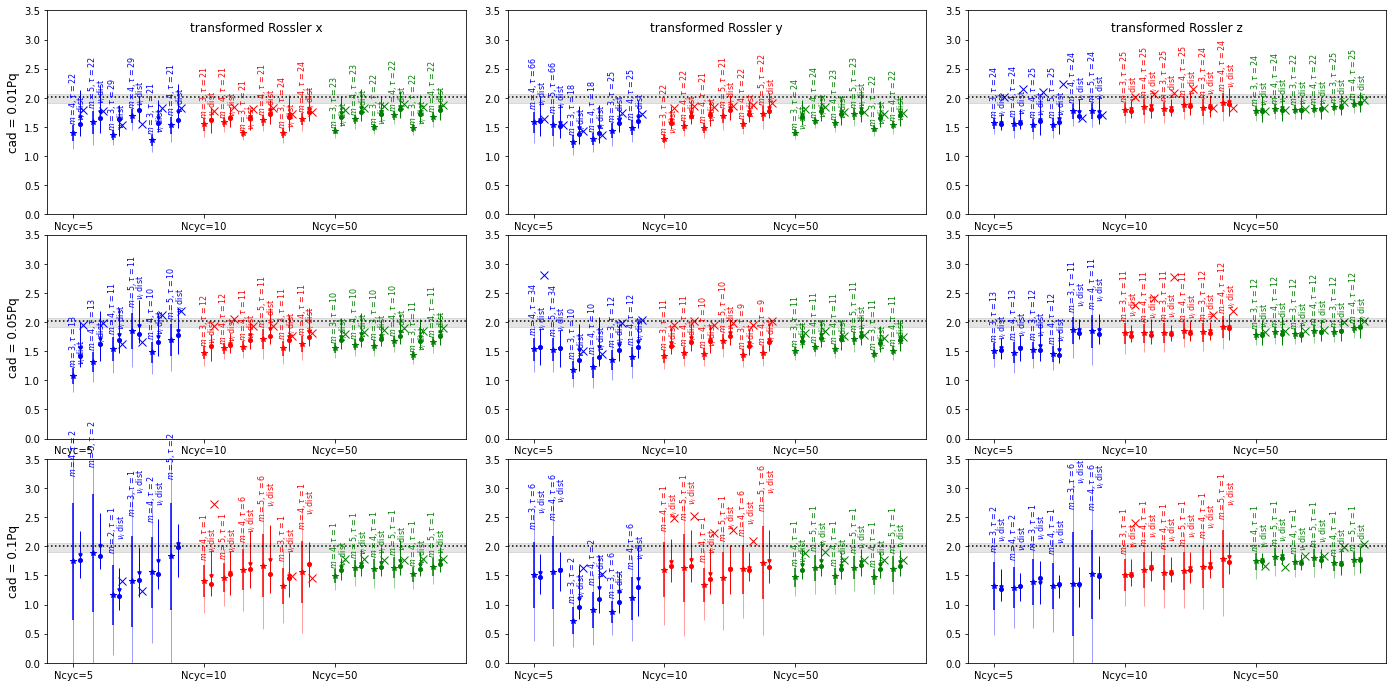

In [ ]:
# "true" C2 values from Sprott & Rowlands 2000
lorenz_C2_lower = 2.049-0.096
lorenz_C2_upper = 2.049+0.096
lorenz_KY = 2.062
rossler_C2_lower = 1.986-0.078
rossler_C2_upper = 1.986+0.078
rossler_KY = 2.013

fig, axes = plt.subplots(3,3,figsize=(24,12))
counters = np.zeros((3,3,3))
for f in transformed_rossler_C0:
    #print(f)
    #C0 = np.load(f)
    #C1 = np.load("./corrDimTesting/" + fileName[:-2] + "C1.npy")
    C2 = np.load(f[:-6] + "C2.npy")
    nArr = np.load(f[:-6] + "nArr.npy")
    #print(np.shape(nArr))
    
    Pq = float(f.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(f.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(f.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(f.split("_v")[1].split("_")[0])
    #print(version)
    tau = int(f.split("tau=")[1].split("_")[0])
    #print(tau)
    m = int(f.split("m=")[1].split("_")[0])
    #print(m)
    
    varname = f.split("transformed_rossler_")[1][0]
    
    ts_f = "./corrDimTesting/transformed_rossler/transformed_rossler_{0}_Pq={1}_cad={2}_Ncyc={3}_v{4}.npy".format(varname,Pq,cad,Ncyc,version)
    
    timeSeries = np.load(ts_f)
    
    N = np.shape(nArr)[0]
    medians = np.percentile(nArr, 50, axis=0)
        
    # exclude values of r where the median of n(r) is <= 10./N . Cutoff is a little arbitrary but the idea is that these points don't have enough neighbors.
    #enoughNeighborsIdxs = np.arange(len(rArr))[medians > 10./N]
    #firstGood = enoughNeighborsIdxs[0]
    
    # exclude values of r where any n(r) are NaN. The time series is not long enough to populate all the neighbors of the points.
    #anyNans = [np.any(~np.isfinite(nArr[:,i])) for i in range(len(rArr))]
    #anyNans = np.array(anyNans)
    #nansIdxs = np.arange(len(rArr))[anyNans]
    #lastGood = nansIdxs[0]
    
    # My code to calculate C2
    try:
        params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr, C2)
        params_dist, params_dist_1sigma = sp.powerLawSlopeDistribution(rArr, nArr)
    except IndexError:
        params_C2 = np.zeros_like(params_C2)
        params_unc_C2 = np.zeros_like(params_unc_C2)
        params_C2[:] = np.nan
        params_unc_C2[:] = np.nan
        
        params_dist = np.zeros_like(params_dist)
        params_dist_1sigma = np.zeros_like(params_dist_1sigma)
        params_dist[:] = np.nan
        params_dist_1sigma[:] = np.nan
    
    #TISEAN C2 calculation
    # Multiple output command example (d2)
    d2_out, msg = tiseanio("d2", '-N', '0', '-M', '1,{0}'.format(m), '-d', '{0}'.format(tau), "-V", "0", data=timeSeries)
    
    # need to figure out the Thelier window but just in the interest of getting the plotting code working:
    """
    fig3,ax3 = plt.subplots(1,1,figsize=(8,6))
    ax3.plot(d2_out["c2"][:,0])
    plt.show()
    """
    tisean_r_arr = d2_out["c2"][-78:-42,0][::-1]
    tisean_C2_arr = d2_out["c2"][-78:-42:,1][::-1]
    
    tisean_params, tisean_params_unc = sp.normal_equation(x=np.log10(tisean_r_arr), y=np.log10(tisean_C2_arr), yerr=np.ones_like(tisean_C2_arr), order=2)
    
    """
    fig2, axes2 = plt.subplots(2,1,figsize=(8,12))
    axes2[0].scatter(d2_out["c2"][:,0], d2_out["c2"][:,1],s=5)
    axes2[0].scatter(tisean_r_arr,tisean_C2_arr,s=10,color='y',alpha=0.5)

    axes2[0].set_yscale('log')
    axes2[0].set_ylim([1e-7,1])
    axes2[0].set_xscale('log')
    axes2[0].set_xlabel("length scale")
    axes2[0].set_ylabel("correlation sum")

    # plot output d2
    axes2[1].scatter(d2_out["d2"][:,0], d2_out["d2"][:,1],s=5)
    #axes2[1].set_yscale('log')
    axes2[1].set_xscale('log')
    axes2[1].set_xlabel("length scale")
    axes2[1].set_ylabel("correlation dimension")
    plt.show()
    """
    
    
    """
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    for i in range(len(params_dist)):
        #ax.plot(rArr, nArr[i], 'k-', marker='None', lw=1, alpha=0.1)
        #ax.plot(rArr[firstGood:lastGood], nArr[i][firstGood:lastGood], 'k-', marker='None', lw=1, alpha=0.1)
        ax.plot(rArr[firstGood:lastGood], (10**params_dist[i][1])*rArr[firstGood:lastGood]**params_dist[i][0], 'r-', marker='None', lw=1, alpha=0.1)
    #ax.plot(rArr, C2, 'ko', ls="None")
    ax.plot(rArr[firstGood:lastGood], C2[firstGood:lastGood], 'ko', ls="None")
    print(params_C2[1])
    ax.plot(rArr[firstGood:lastGood], (10**params_C2[1])*rArr[firstGood:lastGood]**params_C2[0], 'b-', marker='None', lw=2, alpha=1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.show()
    """
    
    if cad==0.01:
        idx_0 = 0
    elif cad==0.05:
        idx_0 = 1
    elif cad==0.1:
        idx_0 = 2

    if "_x_" in f:
        idx_1 = 0
    elif "_y_" in f:
        idx_1 = 1
    elif "_z_" in f:
        idx_1 = 2

    if Ncyc==5:
        start_x = 1
        color = 'b'
        idx_2 = 0
    elif Ncyc==10:
        start_x = 2
        color = 'r'
        idx_2 = 1
    elif Ncyc==50:
        start_x = 3
        color = 'g'
        idx_2 = 2

    #
    #for i in range(len(params_dist)):
    #    axes[idx_0,idx_1].plot(start_x + 0.15*counters[idx_0,idx_1,idx_2], params_dist[i][0],marker='o', color='k',ms=3,alpha=0.05,zorder=i)
    
    # my C2 calculation overall
    axes[idx_0,idx_1].errorbar(start_x + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color=color, elinewidth=1.5,alpha=1.,zorder=2)
    axes[idx_0,idx_1].errorbar(start_x + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0], 2*np.sqrt(params_unc_C2[0,0]), marker='None', color=color, elinewidth=0.75,alpha=0.5,zorder=1)
    
    p16 = np.percentile(params_dist[:,0],16)
    p50 = np.percentile(params_dist[:,0],50)
    v_mean = np.mean(params_dist[:,0])
    p84 = np.percentile(params_dist[:,0],84)
    
    #my C2 calculation from the v_i distribution
    axes[idx_0,idx_1].plot(start_x + 0.05 + 0.15*counters[idx_0,idx_1,idx_2],p50, marker='o',ms=4,color=color,lw=1.,alpha=1,zorder=2)
    axes[idx_0,idx_1].plot(start_x + 0.05 + 0.15*counters[idx_0,idx_1,idx_2],v_mean, marker='*',ms=4,color=color,lw=1.,alpha=1,zorder=2)
    axes[idx_0,idx_1].vlines(x=start_x + 0.05 + 0.15*counters[idx_0,idx_1,idx_2], ymin=p16, ymax=p84, color=color,lw=1.,alpha=1,zorder=1)
    
    #TISEAN 
    axes[idx_0,idx_1].plot(start_x + 0.075 + 0.15*counters[idx_0,idx_1,idx_2],tisean_params[0], marker='x',ms=8,color=color,lw=1.,alpha=1,zorder=2)
    
    axes[idx_0,idx_1].annotate(r"$m={0},\tau={1}$".format(m,tau), (start_x -0.05 + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0]+1.5*np.sqrt(params_unc_C2[0,0])),rotation=90,color=color,fontsize=8,zorder=3)   
    axes[idx_0,idx_1].annotate(r"$\nu_i$ dist".format(m,tau), (start_x + 0.02 + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0]+2*np.sqrt(params_unc_C2[0,0])),rotation=90,color=color,fontsize=8,zorder=3)   

    counters[idx_0,idx_1,idx_2] += 1


axes[0,0].set_ylabel("cad = 0.01Pq", fontsize=12)
axes[1,0].set_ylabel("cad = 0.05Pq", fontsize=12)
axes[2,0].set_ylabel("cad = 0.1Pq", fontsize=12)


axes[0,0].set_title("transformed Rossler x", fontsize=12)
axes[0,1].set_title("transformed Rossler y", fontsize=12)
axes[0,2].set_title("transformed Rossler z", fontsize=12)

x_fb = np.linspace(0.,4.,3)

for ax in np.ravel(axes):
    ax.fill_between(x = x_fb, y1 = rossler_C2_lower*np.ones_like(x_fb), y2 = rossler_C2_upper*np.ones_like(x_fb), color='k',alpha=0.1,zorder=1)
    ax.axhline(y=rossler_KY, ls=":", color='k',zorder=2)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(["Ncyc=5","Ncyc=10","Ncyc=50"])
    ax.set_xlim(0.8,4.)
    ax.set_ylim(0.,3.5)
    

plt.subplots_adjust(hspace=0.1,wspace=0.1)
#plt.show()
plt.savefig("./plots/gp1983implementation/transformed_rossler_recoveredPowerLawSlope_severalTrials.pdf")
